# Quality Control for HiSeq Data

The following code was used to ensure that our pairwise sgRNA library had sufficient counts and diversity. We import raw counts (generated by code run on a high-performance computing cluster), visualize library diversity at T$_0$, and export counts for future analysis. Q-score filtering was performed in the counting script, and we ensured that this filter had a similar effect across all timepoints.

6/28/22 - Ryan Otto

### Import packages and libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import plot_defaults
plot_defaults.change_defaults()

### Define relevant variables

In [2]:
date = '231012'
input_path = 'input_files'
figure_path = 'Figures'
output_path = 'intermediate_files'
gene_names = ['dapA', 'dapB', 'gdhA', 'gltB', 'folA', 'thyA', 'glyA', 'purN', 'purL']
TPs = [-3, 0, 2, 4, 6, 8, 10, 12, 14]
BC_list = ['TGAAAG', 'CCATGC', 'CATGAT']

### Import data

In [3]:
with open(f'{output_path}/231012_repression_mean.pickle', 'rb') as handle:
    qPCR_vals = pickle.load(handle)
# Create a list of sgRNAs sorted by relative repression of their target gene
sgRNA_guides = ['negC_rand_42']
for gene in gene_names:
    match_sgRNAs = [sg for sg in sorted(qPCR_vals[gene], key=qPCR_vals[gene].get) if sg != 'negC_rand_42']
    sgRNA_guides += match_sgRNAs
# Import counts before and after filtering specific bases using a Q30 filter
no_filter_dict = {TP:{} for TP in TPs}
with_filterstep_dict = {TP:{} for TP in TPs}
for TP in TPs:
    for BC in BC_list:
        no_filter_dict[TP][BC] = \
        pd.read_csv(f'{input_path}/no_filter_counts/20210914_T{TP}_{BC}_counts.csv').set_index('Unnamed: 0')
        with_filterstep_dict[TP][BC] = \
        pd.read_csv(f'{input_path}/q30_filter/20210914_T{TP}_{BC}_counts.csv').set_index('Unnamed: 0')

### Visualize distribution of barcoded sgRNA counts at $T_0$

Counts follow the expected lognormal distribution, with few barcoded sgRNA constructs having too few counts to analyze

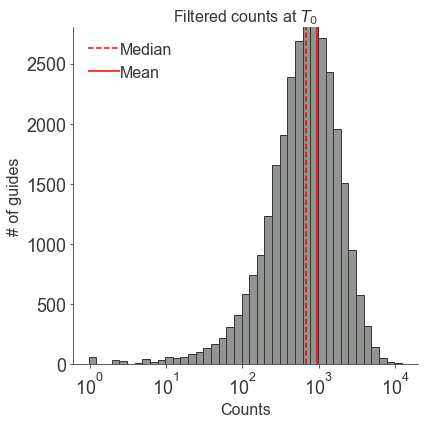

Mean: 957.36
Median: 680.0
Guides with zero counts: 102
0.333% of guides
Guides with < 10 counts: 344
1.124% of guides with < 10 counts


In [4]:
TP = 0
t0_counts = []
for BC in BC_list:
    t0_counts += list(with_filterstep_dict[TP][BC].values.flatten())
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(t0_counts, bins=[10**x for x in np.arange(-0.01, 4.15, 0.1)], color='xkcd:gray', edgecolor='xkcd:dark gray')
ax.vlines(np.median(t0_counts), 0, 3000, color='r', ls='--', label='Median')
ax.vlines(np.round(np.mean(t0_counts), 2), 0, 3000, color='r', label='Mean')
ax.set_xscale('log')
ax.set_title(f'Filtered counts at $T_{TP}$', fontsize=16)
ax.set_xlabel('Counts', fontsize=16)
ax.set_ylabel('# of guides', fontsize=16)
ax.set_ylim([0, 2800])
ax.set_xticks([1, 10, 100, 1000, 10000])
ax.minorticks_off()
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(f'{figure_path}/FigS1A.pdf')
plt.show()
print(f'Mean: {np.round(np.mean(t0_counts), 2)}')
print(f'Median: {np.median(t0_counts)}')
# Print information on poorly represented sgRNAs
print(f'Guides with zero counts: {sum([x == 0 for x in t0_counts])}')
print(f'{np.round(sum([x == 0 for x in t0_counts])/float(len(t0_counts))*100, 3)}% of guides')
print(f'Guides with < 10 counts: {sum([x < 10 for x in t0_counts])}')
print(f'{np.round(sum([x < 10 for x in t0_counts])/float(len(t0_counts))*100, 3)}% of guides with < 10 counts')

### Visualize library completeness at $T_0$

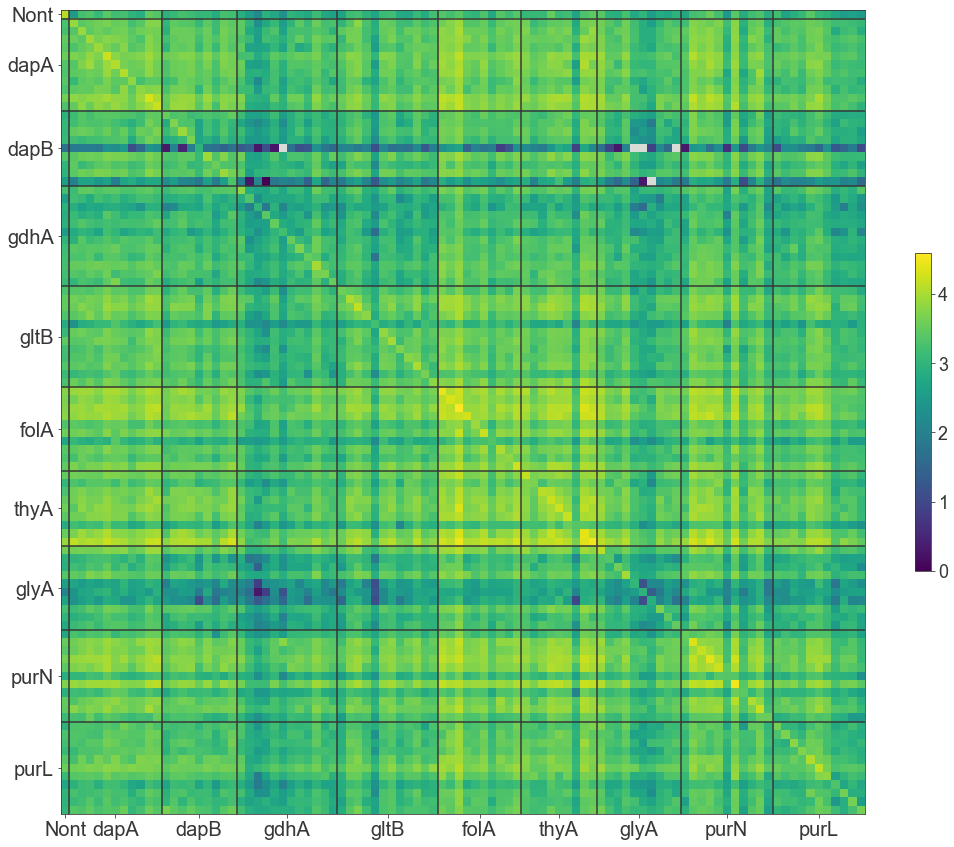

In [5]:
# Pool barcodes and shift to log10 scale for visualization
with_filter_pool_T0 = pd.DataFrame(np.zeros((len(sgRNA_guides), len(sgRNA_guides))), sgRNA_guides, sgRNA_guides)
for BC in BC_list:
    for sgRNA1 in sgRNA_guides:
        for sgRNA2 in sgRNA_guides:
            with_filter_pool_T0.loc[sgRNA1, sgRNA2] += with_filterstep_dict[0][BC].loc[sgRNA1, sgRNA2]
with np.errstate(divide='ignore'):  # We know this data frame has zeros, and the nans that result are desired
    log_with_filter_pool_T0 = np.log10(with_filter_pool_T0)
fig, ax = plt.subplots(figsize=(15, 15))
im = plt.imshow(log_with_filter_pool_T0)
fig.colorbar(im, shrink=0.3)
ax.spines[['top', 'right']].set_visible(True)
ax.tick_params(axis='both', labelsize=20)
ax.set_facecolor('xkcd:light gray')
ax.grid(which='minor', color='xkcd:dark gray', linestyle='-', linewidth=0.25)
grid_lines = [-0.5, 0.5]  # Set up grids to divide sgRNA groups by the gene they target
labels = ['Nont', sgRNA_guides[1].split('_')[0]]  # Target gene names
ax.hlines(0.5, -0.5, len(sgRNA_guides)-0.5, color='xkcd:dark gray')  # Nont sgRNA
ax.vlines(0.5, -0.5, len(sgRNA_guides)-0.5, color='xkcd:dark gray')  # Nont sgRNA
for i, sgRNA in enumerate(sgRNA_guides[1:]):
    if sgRNA.split('_')[0][0:4] != labels[-1]:  # Switching to a new sgRNA group
        grid_lines.append(i+0.5)
        labels.append(sgRNA.split('_')[0])
        ax.hlines(i+0.5, -0.5, len(sgRNA_guides)-0.5, color='xkcd:dark gray')
        ax.vlines(i+0.5, -0.5, len(sgRNA_guides)-0.5, color='xkcd:dark gray')
grid_lines.append(i+1.5)
centers = []  # Center of each sgRNA group
for i, grid in enumerate(grid_lines[:-1]):
    centers.append((grid+grid_lines[i+1])/2)
ax.set_xticks(centers)
ax.set_yticks(centers)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.spines[['top', 'right']].set_visible(True)
plt.tight_layout()
plt.show()

### Compare the effects of filtering across timepoints

We see that the filter affected all timepoints comparably, removing ~30% of our least confident sgRNA counts from each timepoint.

In [6]:
count_no_filter, count_filter = {TP:0 for TP in TPs}, {TP:0 for TP in TPs}
for TP in TPs:
    for BC in BC_list:
        count_no_filter[TP] += sum(no_filter_dict[TP][BC].values.flatten())
        count_filter[TP] += sum(with_filterstep_dict[TP][BC].values.flatten())

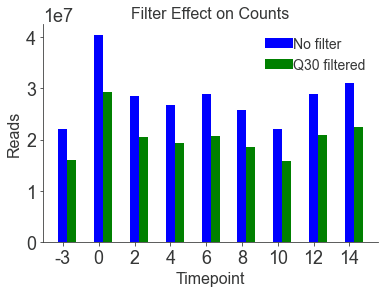

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(range(len(TPs)), [count_no_filter[TP] for TP in TPs], color='b', width=0.25, label='No filter')
ax.bar([x + 0.25 for x in range(len(TPs))], [count_filter[TP] for TP in TPs], color='g', width=0.25,
       label='Q30 filtered')
ax.set_xticks(range(len(TPs)), labels=TPs)
ax.set_ylabel('Reads', fontsize=16)
ax.set_xlabel('Timepoint', fontsize=16)
ax.set_title('Filter Effect on Counts', fontsize=16)
ax.legend()
plt.show()

### Export data

In [8]:
with open(f'{output_path}/{date}_qscore30_sgRNA_counts.pickle', 'wb') as handle:
    pickle.dump(with_filterstep_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)